In [17]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

In [18]:
class CSVLabeledDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform

        self.features = self.data.iloc[:, :-1].values
        self.labels = self.data.iloc[:, -1].values

        self.label_encoder = LabelEncoder()
        self.labels = self.label_encoder.fit_transform(self.labels)

        if self.transform:
            self.features = self.transform.fit_transform(self.features)
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        sample = torch.tensor(self.features[idx], dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return sample, label
    
    def get_label_encoder(self):
        return self.label_encoder

In [19]:
def createDataLoader(train_csv, test_csv, batch_size=32):
    scaler = StandardScaler()

    train_dataset = CSVLabeledDataset(train_csv, transform=scaler)
    test_dataset = CSVLabeledDataset(test_csv, transform=scaler)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_dataset, test_dataset, train_loader, test_loader

In [20]:
# Arquivos CSV de treinamento e teste
train_csv = 'dataset/hars/train.csv'
test_csv = 'dataset/hars/test.csv'

train_dataset, test_dataset, train_loader, test_loader = createDataLoader(train_csv, test_csv)

In [21]:
class Net(nn.Module):
    def __init__(self, input_dim):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(64, 6)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [22]:
input_dim = train_dataset.features.shape[1]
model = Net(input_dim)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print(model)

Net(
  (fc1): Linear(in_features=562, out_features=64, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=64, out_features=6, bias=True)
)


In [23]:
def trainModel(model, train_loader, criterion, optimizer):
  model.train()
  running_loss = 0.0
  correct = 0
  total = 0

  for batch_idx, (x, y) in enumerate(train_loader):
    # data = x.to(device)
    # label = y.to(device)
    
    optimizer.zero_grad()
    logits = model(x)
    loss = criterion(logits, y)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    _, predicted = logits.max(1)
    total += y.size(0)
    correct += predicted.eq(y).sum().item()

  epoch_loss = running_loss / len(train_loader)
  epoch_acc = 100. * correct / total
  return epoch_loss, epoch_acc

def evalModel(model, val_loader, criterion):
  model.eval()
  running_loss = 0.0
  correct = 0
  total = 0

  with torch.no_grad():
    for batch_idx, (x, y) in enumerate(val_loader):
      # data = x.to(device)
      # label = y.to(device)
      logits = model(x)
      loss = criterion(logits, y)

      running_loss += loss.item()
      _, predicted = logits.max(1)
      total += y.size(0)
      correct += predicted.eq(y).sum().item()

  epoch_loss = running_loss / len(val_loader)
  epoch_acc = 100. * correct / total
  return epoch_loss, epoch_acc

In [24]:
num_epochs = 100

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

best_val_acc = 0.0

for epoch in range(num_epochs):
    train_loss, train_acc = trainModel(model, train_loader, criterion, optimizer)
    val_loss, val_acc = evalModel(model, test_loader, criterion)
    
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}')

Epoch 1/100, Train Loss: 0.3581, Train Acc: 87.42, Val Loss: 0.1876, Val Acc: 93.01
Epoch 2/100, Train Loss: 0.1213, Train Acc: 95.91, Val Loss: 0.1603, Val Acc: 93.99
Epoch 3/100, Train Loss: 0.0836, Train Acc: 96.97, Val Loss: 0.1571, Val Acc: 94.10
Epoch 4/100, Train Loss: 0.0721, Train Acc: 97.46, Val Loss: 0.1464, Val Acc: 94.81
Epoch 5/100, Train Loss: 0.0638, Train Acc: 97.65, Val Loss: 0.1934, Val Acc: 93.25
Epoch 6/100, Train Loss: 0.0507, Train Acc: 97.97, Val Loss: 0.1535, Val Acc: 94.60
Epoch 7/100, Train Loss: 0.0487, Train Acc: 98.19, Val Loss: 0.1588, Val Acc: 94.88
Epoch 8/100, Train Loss: 0.0474, Train Acc: 98.19, Val Loss: 0.1462, Val Acc: 94.98
Epoch 9/100, Train Loss: 0.0364, Train Acc: 98.71, Val Loss: 0.1503, Val Acc: 95.18
Epoch 10/100, Train Loss: 0.0333, Train Acc: 98.69, Val Loss: 0.1826, Val Acc: 94.91
Epoch 11/100, Train Loss: 0.0339, Train Acc: 98.71, Val Loss: 0.1741, Val Acc: 95.18
Epoch 12/100, Train Loss: 0.0360, Train Acc: 98.72, Val Loss: 0.1807, Val 

In [25]:
# avaliando modelo sem augmentation
test_loss, test_acc = evalModel(model, test_loader, criterion)
print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}')

Test Loss: 0.4839, Test Acc: 94.84


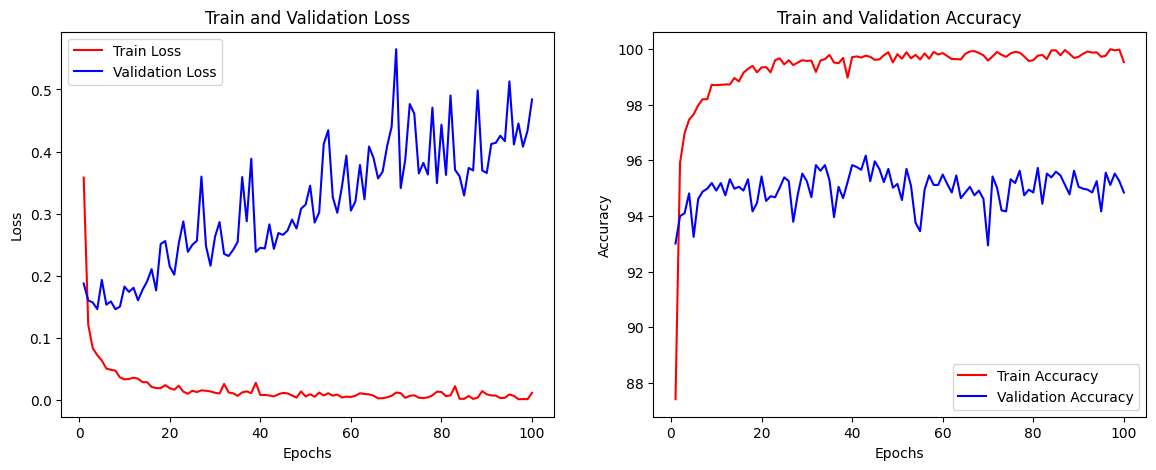

In [26]:
# Plotando a perda e a precisão do modelo sem augmentation
epochs = range(1, num_epochs + 1) # é 36 epocas porque com early stopping so rodou 36 epocas

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'r', label='Train Loss')
plt.plot(epochs, val_losses, 'b', label='Validation Loss')
plt.title('Train and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, 'r', label='Train Accuracy')
plt.plot(epochs, val_accuracies, 'b', label='Validation Accuracy')
plt.title('Train and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

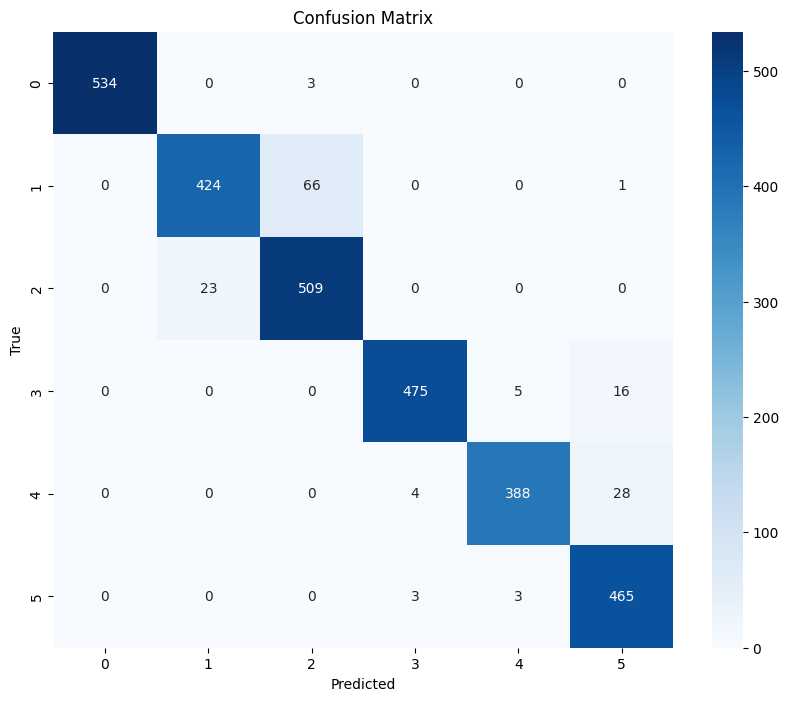

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       537
           1       0.95      0.86      0.90       491
           2       0.88      0.96      0.92       532
           3       0.99      0.96      0.97       496
           4       0.98      0.92      0.95       420
           5       0.91      0.99      0.95       471

    accuracy                           0.95      2947
   macro avg       0.95      0.95      0.95      2947
weighted avg       0.95      0.95      0.95      2947



In [27]:
# Obter previsões do conjunto de teste
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for batch_idx, (x, y) in enumerate(test_loader):
        outputs = model(x)
        _, preds = outputs.max(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

# Calcular a matriz de confusão
cm = confusion_matrix(all_labels, all_preds)

# Visualizar a matriz de confusão
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Relatório de classificação
print(classification_report(all_labels, all_preds))